# Probing the Relationship between Average Regional Temperature, Dewpoint, and Daily Percent Changes in Total Confirmed nCOVID-19 cases

### Background Research:

**Faster deterioration of related SARS Coronavirus on surfaces in hot and humid environments**

Chan, K. H., Peiris, J. S. M., Lam, S. Y., Poon, L. L. M., Yuen, K. Y., & Seto, W. H. (2011). The Effects of Temperature and Relative Humidity on the Viability of the SARS Coronavirus. Advances in Virology, 2011, 1–7. doi: https://doi.org/10.1155/2011/734690

**Median number of days between exposure and developing symptoms**

Lauer, S. A., Grantz, K. H., Bi, Q., Jones, F. K., Zheng, Q., Meredith, H. R., ... & Lessler, J. (2020). The incubation period of coronavirus disease 2019 (COVID-19) from publicly reported confirmed cases: estimation and application. Annals of internal medicine. https://doi.org/10.7326/M20-0504

### Data Sources: 
**nCOVID-19 cases**

Johns Hopkins Center for Systems Science and Engineering. (2020). _Coronavirus COVID-19 Global Cases._ Retrieved on May 15, 2020 from https://github.com/CSSEGISandData/COVID-19/raw/4297d6d4ff566d652874ee41adafd0a5525ed47a/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv 

**Daily Average Climate data**

User Engagement and Services Branch, National Climatic Data Center, NESDIS, NOAA, U.S. Department of Commerce. (2020). _Global Surface Summary of the Day._ Retrieved on March 22, 2020 from ftp://ftp.ncdc.noaa.gov/pub/data/gsod/2020/gsod_2020.tar

**GeoJSON shapefile of international country borders**

Alexandre Bonnasseau. geo-countries dataset. (2018). Retrieved on April 15, 2020 from https://github.com/datasets/geo-countries/raw/master/data/countries.geojson

**Acknowledgements:**

Robert "Bobby" Smith, for his assistance in optimizing my weather station retrieval code

In [373]:
# Multiple dependency imports
import pandas as pd
print('pandas',pd.__version__)
import numpy as np
print('numpy',np.__version__)
import os
import datetime

# Subsetting weather stations within countries depedencies
from shapely.geometry import Polygon, Point
import geojson
import urllib.request

# Climate data retrieval dependencies
from ftplib import FTP
import time

# Climate data unpacking and parsing dependencies
import gzip

# Data analysis and visualization dependencies
import matplotlib as mpl
print('Matplotlib',mpl.__version__)
from matplotlib import pyplot as plt
from scipy import stats
import statsmodels.api as sm
from math import log10

pd.set_option('display.max_rows', 999)

pandas 1.0.3
numpy 1.17.2
Matplotlib 3.1.1


Code for setting the base directory in which all relative directories will be created.

In [374]:
baseDir = ''
while os.path.exists(baseDir) == False:

    baseDir = input('Please enter a directory to use as the base directory for this notebook')

    baseDir = os.path.abspath(baseDir)
    print('estoy loopin')
os.chdir(baseDir)
print(baseDir)

Please enter a directory to use as the base directory for this notebook/home/dreadpirate/PycharmProjects/untitled/
estoy loopin
/home/dreadpirate/PycharmProjects/untitled


In [375]:
if os.path.exists('./climate'):
    print('climate subdirectory already exists')
else:
    print('creating climate subdirectory')
    os.mkdir('./climate')

if os.path.exists('./geojson'):
    print('geojson subdirectory already exists')
else:
    print('creating geojson subdirectory')
    os.mkdir('./geojson')

    
os.chdir('./climate')

climate subdirectory already exists
geojson subdirectory already exists


# Data Acquisition:

## Searching GSOD Database for Weather Stations within Countries of Interest

In [376]:
# Checks if GSOD index file is already present in directory. If not, retrieves via FTP
if os.path.isfile('./isd-history.txt'):
    print('Weather station index already exists')
else:
    email = input('Must download weather station index. Enter your UMBC email address to sign into NOAA\'s FTP server')
    noaaFTP = FTP('ftp.ncdc.noaa.gov',user='ftp',passwd=email)
    noaaFTP.cwd('./pub/data/noaa/')
    output = os.getcwd()
    noaaFTP = noaaFTP.retrbinary('RETR ' + 'isd-history.txt', open(output+'/isd-history.txt', 'wb').write)
    noaaFTP.close()

# Reads GSOD index file into DataFrame

with open('isd-history.txt', 'r') as f:
    # Skip first 20 rows of text description, set header, and then manually set the datatypes for columns that would
    # otherwise be misinterpreted as numerical data
    df = pd.read_fwf(f, skiprows=20, header=0, colspecs='infer',
                     dtype={'USAF': object, 'WBAN': object, 'STATION NAME': 'string', 'CTRY': 'string', 'ST': 'string',
                            'CALL': 'string', 'BEGIN': object, 'END': object})
    f.close()

Weather station index already exists


In [377]:
# Convert begin and end columns to datetime format according to format string
df['BEGIN'] = pd.to_datetime(df['BEGIN'], format='%Y%m%d')
df['END'] = pd.to_datetime(df['END'], format='%Y%m%d')


# Filters out weather stations that don't have up-to-date data
df = df[df['END'] > pd.to_datetime('20200301', format='%Y%m%d')]

In [378]:
# Creating a new column of tuples containing the latitudes and longitudes
coordlist = []
lat = []
lon = []
# Create a list of latitudes
for latval in df['LAT']:
    lat.append(round(latval,3))
# Create a list of the longitude values
for lonval in df['LON']:
    lon.append(round(lonval,3))
    

# Create a list of tuples (longitude,latitude)
for i in range(len(lat)):
    coordlist.append((round(lon[i],3),round(lat[i],3)))
    
# Insert list of tuples as a new column and delete individual value lists
df.insert(11,column='COORDPAIR',value=coordlist)
del lat, lon, coordlist

In [379]:
class Country:
    def __init__(self, Feature):
        self.Feature = Feature


    def getID(self):
        return self.Feature.id

    def getName(self):
        return self.Feature.properties['ADMIN']

    def getPolygons(self):
        polygons = []
        if self.Feature.geometry.type == "MultiPolygon":
            for poly in self.Feature.geometry.coordinates:
                polygons.append(poly[0])


        elif self.Feature.geometry.type == "Polygon":
            polygons.append(self.Feature.geometry.coordinates[0])

        return polygons

    def getGeomType(self):
        return self.Feature.geometry.type


In [380]:
class CountryContainer:
    def __init__(self, GeoJsonFilepath):

        self.GeoJsonFilepath = GeoJsonFilepath

        self.GeoJson = None

        self.Countries = list()

        self.load()



    def load(self):
        with open(self.GeoJsonFilepath, 'r') as f:
            self.GeoJson = geojson.load(f)
            f.close()

        for feature in self.GeoJson.features:
            self.Countries.append(Country(feature))

    def getCountryByName(self,name):

        for ctry in self.Countries:

            if ctry.getName() == name:
                return ctry

        print('could not find', name)
        return None


In [384]:
# Creates a CountryContainer object out of the MultiFeature geojson file, which in turn creates a list of
# Country objects out of every geojson Feature within it.
if os.path.exists('../geojson/countries.geojson'):
    print('Countries geojson file already exists')
else:
    with open('../geojson/countries.geojson','w') as geo:
        print('Countries geojson file does not exist, downloading from github and writing to',os.path.abspath('../geojson/countries.geojson'))
        for line in urllib.request.urlopen('https://github.com/datasets/geo-countries/raw/master/data/countries.geojson'):
            geo.write(line.decode())
            
        geo.close()
        
allCountries = CountryContainer("../geojson/countries.geojson")

Countries geojson file does not exist, downloading from github and writing to /home/dreadpirate/PycharmProjects/untitled/geojson/countries.geojson


In [385]:
[country.getName() for country in allCountries.Countries]

['Aruba',
 'Afghanistan',
 'Angola',
 'Anguilla',
 'Albania',
 'Aland',
 'Andorra',
 'United Arab Emirates',
 'Argentina',
 'Armenia',
 'American Samoa',
 'Antarctica',
 'Ashmore and Cartier Islands',
 'French Southern and Antarctic Lands',
 'Antigua and Barbuda',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Burundi',
 'Belgium',
 'Benin',
 'Burkina Faso',
 'Bangladesh',
 'Bulgaria',
 'Bahrain',
 'The Bahamas',
 'Bosnia and Herzegovina',
 'Bajo Nuevo Bank (Petrel Is.)',
 'Saint Barthelemy',
 'Belarus',
 'Belize',
 'Bermuda',
 'Bolivia',
 'Brazil',
 'Barbados',
 'Brunei',
 'Bhutan',
 'Botswana',
 'Central African Republic',
 'Canada',
 'Switzerland',
 'Chile',
 'China',
 'Ivory Coast',
 'Clipperton Island',
 'Cameroon',
 'Cyprus No Mans Area',
 'Democratic Republic of the Congo',
 'Republic of Congo',
 'Cook Islands',
 'Colombia',
 'Comoros',
 'Cape Verde',
 'Costa Rica',
 'Coral Sea Islands',
 'Cuba',
 'Curaçao',
 'Cayman Islands',
 'Northern Cyprus',
 'Cyprus',
 'Czech Republic',
 'Germ

In [386]:
def weatherInCountry(weatherdf,ctryobj):
    """
    Takes a dataframe of weather stations and their coordinates (lon,lat) and a geojson of the Country class
    and returns a dataframe subsetted to only the weather stations which lie within the country's coordinates
    :param weatherdf:
    :param ctryobj:
    :return:
    """
    borders = ctryobj.getPolygons()
    polys = []
    # Gets every polygon that makes up the country, converts it to a shapely Polygon object, and deposits it in
    # list polys
    for poly in borders:
        polys.append(Polygon(poly))

    # Ind = row index counter
    ind = -1
    stations = []
    # Iterates through every coordinate pair in the weather station dataframe and checks whether the point lies
    # within any of the country polygons using shapely's .contains method. Appends the index number to the list
    # for stations that lie within the country
    for coord in weatherdf['COORDPAIR']:
        ind+=1
        for poly in polys:
            if poly.contains(Point(coord)):
                stations.append(ind)

    return weatherdf.iloc[stations]


## Climate Data Retrieval

In [387]:
SK = allCountries.getCountryByName('South Korea')
weatherdfSK = weatherInCountry(df,SK)

In [388]:
def getStationIDs(weatherdf):
    """
    Extracts and formats the full, formatted weather station ID from a subset of the
    weather station index dataframe
    """
    return ['{}-{}'.format(rowSeries['USAF'],rowSeries['WBAN']) for index, rowSeries in weatherdf.iterrows()]

In [393]:
# Simpler, if sloppier, to establish output lists outside the function because it's called individually for
# each file in the GSOD 2020 database
gsodpaths = []

def getPaths(stringinput):
    """
    Helper function which generates a list of the full file names from the FTP server by checking them
    against the list of formatted weather station IDs
    :param stringinput:
    :return:
    """
    for id in stationIDs:
        if stringinput.startswith(id):
            gsodpaths.append(stringinput)

In [394]:
def dlGsod(stringinput,destination):
    """
    Takes a file name from the FTP server as input and downloads the corresponding datafile if
    one of the target station IDs is in the beginning of the filename. Also logs the file's domain
    :param stringinput:
    :return:
    """
    try:
        basepath = os.path.abspath(destination)
    except:
        print('Problem with destination path, aborting.')
        return None
    
    for id in stationIDs:
        if stringinput.startswith(id):
            # Checks if the dllog text file already exists. If so, download URL is appended rather than overwritten
            if os.path.isfile(basepath+'/dllog.txt'):
                dllog = open(basepath+'/dllog.txt', 'a')
                outputPath = basepath + '/' + stringinput
                dllog.write('\n'+time.asctime()+': '+'ftp.ncdc.noaa.gov/pub/data/gsod/2020/'+stringinput)
                noaaFTP.retrbinary('RETR '+stringinput, open(outputPath,'wb').write)
            # This creates the log file and writes the first download URL
            else:
                dllog = open(basepath+'/dllog.txt', 'w')
                outputPath = basepath + '/' + stringinput
                dllog.write(time.asctime()+': '+'ftp.ncdc.noaa.gov/pub/data/gsod/2020/' + stringinput)
                noaaFTP.retrbinary('RETR ' + stringinput, open(outputPath, 'wb').write)

    dllog.close()


In [396]:
stationIDs = getStationIDs(weatherdfSK)

# Opens FTP connection with the NCDC NOAA Global Summary of the Day database
try:
    noaaFTP = FTP('ftp.ncdc.noaa.gov',user='ftp',passwd=email)
except NameError:
    email = input('Must download weather stations. Enter your UMBC email address to sign into NOAA\'s FTP server')
    noaaFTP = FTP('ftp.ncdc.noaa.gov',user='ftp',passwd=email)

# Changes working directory to the 2020 data files
noaaFTP.cwd('./pub/data/gsod/2020/')

# Lists every file in the current directory and runs them as an input into getPaths, which results in a list
# of the filenames for the data from the target weather stations in gsodpaths
noaaFTP.retrlines('NLST',callback=getPaths)

'226 Transfer complete'

In [397]:
# Downloads from FTP paths using dlGsod
for path in gsodpaths:
    dlGsod(path,destination='./SK/')

noaaFTP.quit()

'221 Goodbye.'

## Create Time Series of daily average values of relevant climate statistics

In [398]:
def unpackWeatherStations(path):
    """
    Takes a directory path containing gzip archives of GSOD weather data, unpacks all of them into dataframes,
    and returns a list of the dataframe objects
    """
    # Store cwd to return to it after execution, then change working directory to path
    CWD = os.getcwd()
    os.chdir(path)

    # Put every .gz filename in a list
    fileList = []
    for file in os.listdir(path):
        if file.endswith('.gz'):
            fileList.append(file)

    # Default sort the file list by name
    fileList.sort()

    for index, file in enumerate(fileList):

        with gzip.open(file, 'rt') as f:
            unzipped = pd.read_fwf(f,
                                   colspecs=[(0, 6), (7, 12), (14, 22), (24, 30), (31, 33),
                                             (35, 41), (42, 44), (46, 52), (53, 55), (57, 63),
                                             (64, 66), (64, 66), (68, 73), (74, 76), (78, 83),
                                             (84, 86), (88, 93), (95, 100), (102, 108), (108, 109),
                                             (110, 116), (116, 117), (118, 123), (123, 124), (125, 130),
                                             (132, 138)],
                                   dtype={'STN---': object, 'WBAN': object,
                                          'YEARMODA': object, 'TEMP': 'float64',
                                          'DEWP': 'float64', 'SLP': 'float64', 'STP': 'float64',
                                          'VISIB': 'float64', 'WDSP': 'float64', 'MXSPD': 'float64',
                                          'GUST': 'float64', 'MAX': 'float64', 'MIN': 'float64',
                                          'PRCP': 'float64', 'SNDP': 'float64', 'FRSHTT': object
                                          })
            f.close()
        # Preserve all rows, but only retain columns containing data of interest
        unzipped = unzipped.loc[:,['STN---','WBAN','YEARMODA','TEMP','DEWP','MAX','MIN']]
        # Change YEARMODA to pandas timestamp datatype and makes the date the index
        unzipped['YEARMODA'] = pd.to_datetime(unzipped['YEARMODA'], format='%Y%m%d')
        unzipped.set_index('YEARMODA',inplace=True)
        # Replaces stand-in values for missing data with standard NaNs
        unzipped.mask(lambda x: x == 999.9, inplace=True)
        unzipped.mask(lambda x: x == 99.99, inplace=True)
        unzipped.mask(lambda x: x == 9999.9, inplace=True)
        # Assigns newly formed dataframe in-place to list fileList
        fileList[index] = unzipped

    # Returns to original working directory before terminating
    os.chdir(CWD)
    return fileList

In [399]:
weatherStations = unpackWeatherStations('/home/dreadpirate/PycharmProjects/untitled/climate/SK')

# Create a dataframe with the same index scheme as the weather stations into which the average data will be
# recorded

In [400]:
avgDF = pd.DataFrame().reindex_like(weatherStations[0])
#Adds a column for counting the number of stations the the average was calculated from
avgDF['NSTATIONS'] = np.zeros(shape=avgDF.shape[0],dtype='int')
# Iterates over dates in the index and aggregates the mean value (with NaN handling) for each climate variable 
# in the list of weather station dataframes
missing = []
for date in avgDF.index:
    #print(date)
    # Long-form iteration over each station per date in order to implement the try-except block to handle
    # stations missing data on particular dates
    temp = []
    dewp = []
    maxtemp = []
    mintemp = []
    nstations = 0
    for station in weatherStations:
        try:
            nstations += 1
            temp.append(station.at[date,'TEMP'])
            dewp.append(station.at[date,'DEWP'])
            maxtemp.append(station.at[date,'MAX'])
            mintemp.append(station.at[date,'MIN'])
        except KeyError:
            print('Missing row for station',station.iloc[0,0],station.iloc[0,1],'on',date)
            missing.append((station.iloc[0,0]+station.iloc[0,1],date))
            nstations -= 1
        
    avgDF.loc[date, 'NSTATIONS'] = nstations
    avgDF.loc[date, 'TEMP'] = np.nanmean(temp)
    avgDF.loc[date, 'DEWP'] = np.nanmean(dewp)
    avgDF.loc[date, 'MAX'] = np.nanmean(maxtemp)
    avgDF.loc[date, 'MIN'] = np.nanmean(mintemp)

# Finally, drops ID columns which are lost in aggregation
avgDF = avgDF.drop(labels=['STN---','WBAN'],axis=1)

Missing row for station 471105 99999 on 2020-02-07 00:00:00
Missing row for station 471105 99999 on 2020-02-10 00:00:00
Missing row for station 471105 99999 on 2020-02-11 00:00:00
Missing row for station 471105 99999 on 2020-02-12 00:00:00
Missing row for station 471105 99999 on 2020-02-13 00:00:00
Missing row for station 471105 99999 on 2020-02-14 00:00:00
Missing row for station 471105 99999 on 2020-02-16 00:00:00
Missing row for station 471105 99999 on 2020-02-17 00:00:00
Missing row for station 471105 99999 on 2020-02-18 00:00:00
Missing row for station 471105 99999 on 2020-02-19 00:00:00
Missing row for station 471105 99999 on 2020-02-20 00:00:00
Missing row for station 471105 99999 on 2020-02-21 00:00:00
Missing row for station 471105 99999 on 2020-02-23 00:00:00
Missing row for station 471315 99999 on 2020-02-23 00:00:00
Missing row for station 471105 99999 on 2020-02-24 00:00:00
Missing row for station 471105 99999 on 2020-02-25 00:00:00
Missing row for station 471105 99999 on 

In [401]:
# Checking the dates and total number of stations still involved in avg
for tup in missing:
    print(tup[1],avgDF.loc[tup[1],'NSTATIONS'])

2020-02-07 00:00:00 73
2020-02-10 00:00:00 73
2020-02-11 00:00:00 73
2020-02-12 00:00:00 73
2020-02-13 00:00:00 73
2020-02-14 00:00:00 73
2020-02-16 00:00:00 73
2020-02-17 00:00:00 73
2020-02-18 00:00:00 73
2020-02-19 00:00:00 73
2020-02-20 00:00:00 73
2020-02-21 00:00:00 73
2020-02-23 00:00:00 72
2020-02-23 00:00:00 72
2020-02-24 00:00:00 73
2020-02-25 00:00:00 73
2020-02-26 00:00:00 73
2020-02-27 00:00:00 73
2020-02-28 00:00:00 73
2020-03-01 00:00:00 73
2020-03-02 00:00:00 73
2020-03-03 00:00:00 73
2020-03-04 00:00:00 73
2020-03-05 00:00:00 73
2020-03-06 00:00:00 73
2020-03-08 00:00:00 73
2020-03-09 00:00:00 73
2020-03-10 00:00:00 73
2020-03-11 00:00:00 73
2020-03-12 00:00:00 73
2020-03-13 00:00:00 73
2020-03-15 00:00:00 73
2020-03-16 00:00:00 73
2020-04-12 00:00:00 73
2020-05-07 00:00:00 73
2020-05-08 00:00:00 73
2020-05-10 00:00:00 73
2020-05-11 00:00:00 73
2020-05-12 00:00:00 72
2020-05-12 00:00:00 72
2020-05-13 00:00:00 71
2020-05-13 00:00:00 71
2020-05-13 00:00:00 71


## COVID Case Data Retrieval and Data Structuring

In [404]:
# Returns to base directory
os.chdir('..')
os.getcwd()

'/home/dreadpirate/PycharmProjects'

In [406]:
if os.path.isfile('./ccases/time_series_covid19_confirmed_global.csv'):
    print('confirmed case file already present')
    caseData = pd.read_csv('./ccases/time_series_covid19_confirmed_global.csv',index_col=False)
else:
    print('reading csv from github')
    caseData = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/4297d6d4ff566d652874ee41adafd0a5525ed47a/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv',index_col=False)
    
if os.path.isfile('./ccases/time_series_covid19_deaths_global.csv'):
    print('confirmed mortality file already present')
    mortData = pd.read_csv('./ccases/time_series_covid19_deaths_global.csv',index_col=False)
else:
    print('reading csv from github')
    mortData = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/4297d6d4ff566d652874ee41adafd0a5525ed47a/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')

confirmed case file already present
confirmed case file already present


In [407]:
# Select country to convert to a pandas time-indexed Series via query

caseDataSK = caseData.query('`Country/Region` == "Korea, South"')

In [408]:
# First four columns are Province, country, lat, and longitude, thus discarded during conversion
caseDataSK = pd.Series(data=caseDataSK.iloc[:,4::].values[0],index=list(caseData.columns[4::]),name='South Korea')
caseDataSK.index = pd.to_datetime(caseDataSK.index, infer_datetime_format=True)

In [409]:
# Same procedure for mortality data

mortData = pd.read_csv('./ccases/time_series_covid19_deaths_global.csv')
mortDataSK = mortData.query('`Country/Region` == "Korea, South"')
mortDataSK = pd.Series(data=mortDataSK.iloc[:,4::].values[0],index=list(caseData.columns[4::]),name='South Korea')
mortDataSK.index = pd.to_datetime(mortDataSK.index, infer_datetime_format=True)

In [410]:
# Combine the case and mortality series into dataframe
combinedSK = pd.concat(objs=[caseDataSK,mortDataSK],keys=['CumuCases','CumuDeaths'],axis=1)

In [411]:
# Create a new comprehensive Dataframe
combinedSK = pd.concat(objs=[caseDataSK,mortDataSK],keys=['CumuCases','CumuDeaths'],axis=1)

# Note: no reported increase in cases on 3-23 despite being on a massive rising trend. Resolve with manual
# interpolation
difference = combinedSK.loc[pd.to_datetime('2020-03-24')]['CumuCases']-combinedSK.loc[pd.to_datetime('2020-03-22')]['CumuCases']

combinedSK.loc[pd.to_datetime('2020-03-23')]['CumuCases'] += difference//2

# Adds day-to-day increases in cases and deaths as separate columns
combinedSK['NewCases'] = combinedSK['CumuCases'].diff(1)
combinedSK['NewDeaths'] = combinedSK['CumuDeaths'].diff(1)

# Adds averaged climate data
combinedSK = combinedSK.join(avgDF.loc[pd.to_datetime('2020-01-16'):,:],how='right')

# Data Analysis

### Hypothesis
If high temperature or humidity significantly reduces transmission of COVID-19, then fluctuations in the relative increase in cases and/or mortality day-to-day should correlate with fluctuations in those climate measures

### Methodology
Calculate linear regressions of daily percent change in nCOVID-19 cases in terms of regional average temperature and average temperature-average dew point differential. If there is a strong relationship, the regression will have a large R^2 (at least 0.20) with a p_value below 0.05

Overview of climate variables. 
- Day averages for each station are composed of many measurements, so the mean's position relative to average maxima and minima varies
- The smaller the difference between the dew point and mean temperature, the more humid the day

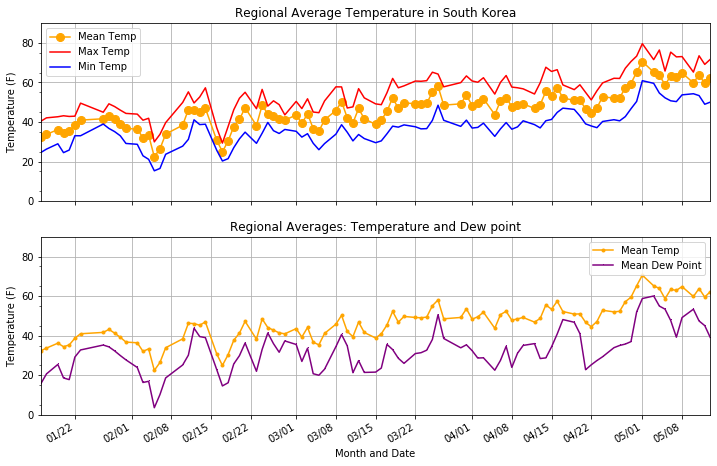

In [222]:
# These objects will be used to place major ticks for each month and minor ticks every seven days before the
# 28th of each month
days = mpl.dates.DayLocator(bymonthday=range(1,28,7))
months = mpl.dates.MonthLocator()
# This creates month/day labels
days_format = mpl.dates.DateFormatter('%m/%d')

# Create two subplots 
figure, ax = plt.subplots(2,1,sharex=True)

# Setting shared parameters
for axis in ax:
    axis.set_ylabel('Temperature (F)')
    axis.set_xlabel('Month and Date')
    
    axis.xaxis.set_major_locator(days)
    axis.xaxis.set_major_formatter(days_format)
    axis.xaxis.set_minor_locator(days)
    
    axis.set_yticks(range(5,80,10),minor = True)
                    
    axis.set_xlim(combinedSK.index.values[0],combinedSK.index.values[-1])
    axis.set_ylim(0,90)
                    
    axis.grid(True)

# Temperature plot params
# Plot average mean temp, average maximum temp, and average minimum temp
ax[0].plot(combinedSK.index.values,combinedSK['TEMP'],color='orange',marker='.',markersize='16')
ax[0].plot(combinedSK.index.values,combinedSK['MAX'],color='red')
ax[0].plot(combinedSK.index.values,combinedSK['MIN'],color='blue')
ax[0].set_title('Regional Average Temperature in South Korea')
ax[0].legend(['Mean Temp','Max Temp','Min Temp'])
                    
#Dew point plot 
ax[1].plot(combinedSK.index.values,combinedSK['TEMP'],color='orange',marker='.')      
ax[1].plot(combinedSK.index.values,combinedSK['DEWP'],color='purple',marker=',')
                    
ax[1].set_title('Regional Averages: Temperature and Dew point')
ax[1].legend(['Mean Temp','Mean Dew Point'])

#Automatically raises the bottom of the figure and fits dates for readability
figure.autofmt_xdate()
figure.set_figwidth(12)
figure.set_figheight(8)

plt.show()

Overview of cumulative confirmed cases:
- Log y scale: Each major tick is an order of magnitude
- Note: Jump in cases between 02/15 and 02/22 appears to be tied to a spike in cases tied to a single individual reported on 02/19 per https://www.reuters.com/article/us-china-health-southkorea-cases/south-korea-reports-20-new-coronavirus-cases-church-services-at-center-of-outbreak-idUSKBN20D02O
- Consistent daily increase in cases begins after January 31st
- Number of new cases never rises above 100 after April 1st


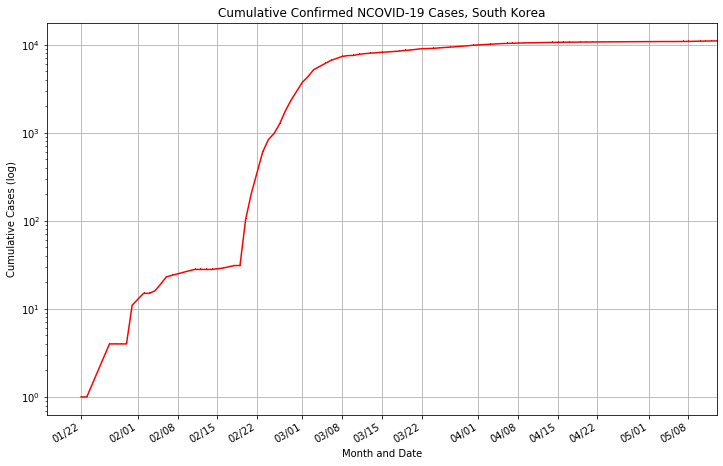

In [413]:
#These objects will be used to place major ticks for each month and minor ticks for each day
days = mpl.dates.DayLocator(bymonthday=range(1,28,7))
months = mpl.dates.MonthLocator()
#This creates month/day labels
days_format = mpl.dates.DateFormatter('%m/%d')

figure, ax = plt.subplots()
ax.plot_date(combinedSK.index.values,combinedSK['CumuCases'],
             linestyle='-',marker=',',c='red')
ax.set_title('Cumulative Confirmed NCOVID-19 Cases, South Korea')
ax.set_ylabel('Cumulative Cases (log)')
ax.set_xlabel('Month and Date')

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(days_format)
ax.xaxis.set_minor_locator(days)

# Sets the width of the plot to map with the date range. Offset due to index beginning at 01-16-2020 but covid
# data beginning at 1-22-2020
ax.set_xlim(combinedSK.index.values[0],combinedSK.index.values[-1])

ax.set_yscale('log')

# Adds major gridlines
ax.grid(True)

# Automatically raises the bottom of the figure and fits dates for readability
figure.autofmt_xdate()
figure.set_figwidth(12)
figure.set_figheight(8)

plt.show()

Overview of cumulative confirmed cases:
- Log y scale: Each major tick is an order of magnitude
- First death is on February 20

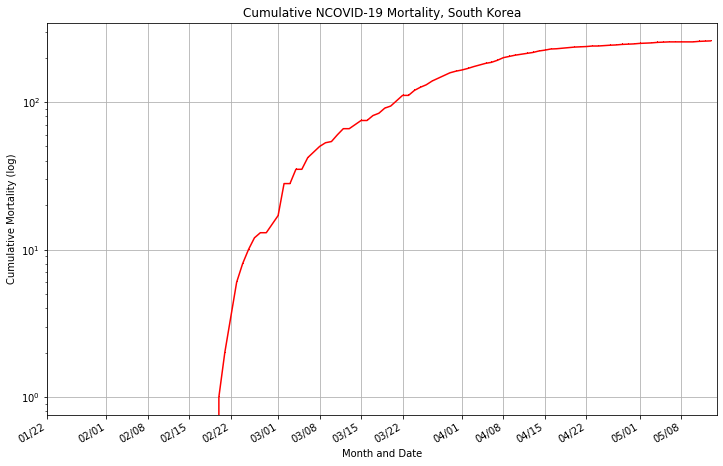

In [414]:
# These objects will be used to place major ticks for each month and minor ticks for each day
days = mpl.dates.DayLocator(bymonthday=range(1,28,7))
months = mpl.dates.MonthLocator()
# This creates month/day labels
days_format = mpl.dates.DateFormatter('%m/%d')

figure, ax = plt.subplots()
ax.plot_date(combinedSK.index.values,combinedSK['CumuDeaths'],
             linestyle='-',marker=',',c='red')
ax.set_title('Cumulative NCOVID-19 Mortality, South Korea')
ax.set_ylabel('Cumulative Mortality (log)')
ax.set_xlabel('Month and Date')

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(days_format)
ax.xaxis.set_minor_locator(days)

# Sets the width of the plot to map with the date range
ax.set_xlim(mortDataSK.index.values[0],mortDataSK.index.values[-1])

ax.set_yscale('log')

# Adds major gridlines
ax.grid(True)

# Automatically raises the bottom of the figure and fits dates for readability
figure.autofmt_xdate()
figure.set_figwidth(12)
figure.set_figheight(8)

plt.show()

Assume that median time between exposure and developing symptoms (and therefore becoming much more likely to get tested) is 5 days then a time lag analysis between climate conditions 5 days prior to a given date should improve fit.

Since the cumulative number of cases only starts growing consistently after January 31st and the number of new cases never rises above 100 after April 1st, it is safe to assume that the greatest amount of transmission occurred in between these dates.

In [418]:
# Percent Change in cumulative cases from cumulative cases 1 and 5 days prior, respectively
combinedSK['PctChange1Day'] = combinedSK['CumuCases'].pct_change(periods=1)
combinedSK['PctChange5Day'] = combinedSK['CumuCases'].pct_change(periods=5)

In [419]:
# 1 and 5-day timelags for change in cumulative mortality
combinedSK['PctMort1Day'] = combinedSK['CumuDeaths'].pct_change(periods=1)
combinedSK['PctMort5Day'] = combinedSK['CumuDeaths'].pct_change(periods=5)

In [420]:
# Adds a column for the daily differential between average temperature and average dew point
combinedSK['TEMP-DEWP'] = combinedSK['TEMP']-combinedSK['DEWP']

In [423]:
# Pairs the percent change in cumulative cases at a given date with the average temperature on that day
tempCases = [(combinedSK['TEMP'].iloc[i-1],combinedSK['PctChange1Day'].iloc[i]) for i in range(11,62)]
# Percent change in cumulative cases from five days ago in terms of avg temperature five days ago
offsetTempCases = [(combinedSK['TEMP'].iloc[i-5],combinedSK['PctChange5Day'].iloc[i]) for i in range(11,62)]

# One-day offset: percent change in mortality in terms of average temperature
tempMort = [(combinedSK['TEMP'].iloc[i-1],combinedSK['PctMort1Day'].iloc[i]) for i in range(11,62)]
# Five-day offset: percent change in mortality in terms of average temperature
offsetTempMort = [(combinedSK['TEMP'].iloc[i-5],combinedSK['PctMort5Day'].iloc[i]) for i in range(11,62)]

# One-day offset: percent change cumulative cases in terms of temperature-dewpoint differential
diffCases = [(combinedSK['TEMP-DEWP'].iloc[i-1],combinedSK['PctChange1Day'].iloc[i]) for i in range(11,62)]
# Five-day offset: percent change cumulative cases in terms of temperature-dewpoint differential
offsetDiffCases = [(combinedSK['TEMP-DEWP'].iloc[i-5],combinedSK['PctChange5Day'].iloc[i]) for i in range(11,62)]

# One-day offset: percent change cumulative mortality in terms of temperature-dewpoint differential
diffMort = [(combinedSK['TEMP-DEWP'].iloc[i-1],combinedSK['PctMort1Day'].iloc[i]) for i in range(11,62)]
# Five-day offset: percent change cumulative mortality in terms of temperature-dewpoint differential
offsetDiffMort = [(combinedSK['TEMP-DEWP'].iloc[i-5],combinedSK['PctMort5Day'].iloc[i]) for i in range(11,62)]


# Data frame for recording linear regression statistics
regressionResults = pd.DataFrame(data = None,columns = ['RSQUARED','PVALUE','SLOPE'])
arrays = [['cases','cases','cases','cases','mortality','mortality','mortality','mortality'],
         ['temp','temp','diff','diff','temp','temp','diff','diff'],
         [1,5,1,5,1,5,1,5]]
multi = pd.MultiIndex.from_arrays(arrays,names=['Measure','ClimateVar','Timelag'])
regressionResults = regressionResults.reindex(index=multi)

In [341]:
def casesAndTemp(tcx,tcy):
    figure, ax = plt.subplots()
    #Plot average mean temp and dew point. Dew point varies quite a bit hourly, but can roughly assume that days
    #with a smaller difference between mean temp and dew point were more humid
    ax.scatter(x=tcx,y = tcy)
    #Plot linear regression
    # ax.plot(range(30,60,2),[(x*slope)+intercept for x in range(30,60,2)],color='red')

#     ax.set_title('Cumulative Cases as a Function of Average Temperature')
#     ax.set_ylabel('Percent Change in Cases')
#     ax.set_xlabel('Mean Temperature (Fahrenheit)')Proc
    #Label regression line with formula and r^2 value
    # ax.text(31,135,'y = {}x + {}'.format(round(slope,3),round(intercept,2),))
    # ax.text(31,130,'r^2 = {}'.format(round(r_value**2,3)))

    # ax.set_xlim(30,60)
    # ax.set_xticks(range(30,60,1))
    # ax.set_ylim(90,260)
    # ax.set_yticks(range(90,260,10))

    figure.set_figwidth(12)
    figure.set_figheight(8)



Plot in which percent change in cumulative cases from one day ago is plotted as a function of avg temperature one day ago

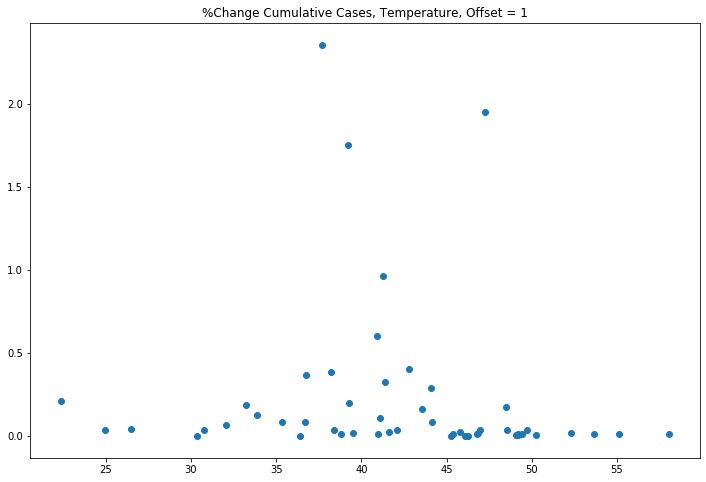

In [428]:
tcx = np.array([x[0] for x in tempCases])
tcy = np.array([y[1] for y in tempCases])

casesAndTemp(tcx,tcy)
plt.title('%Change Cumulative Cases, Temperature, Offset = 1')

slope, intercept, r_value, p_value, std_err = stats.linregress(tcx,tcy)

regressionResults.loc[('cases','temp',1),'RSQUARED'] = r_value**2
regressionResults.loc[('cases','temp',1),'PVALUE'] = p_value
regressionResults.loc[('cases','temp',1),'SLOPE'] = slope


Plot in which percent change in cumulative cases from five days ago is plotted as a function of avg temperature five days ago

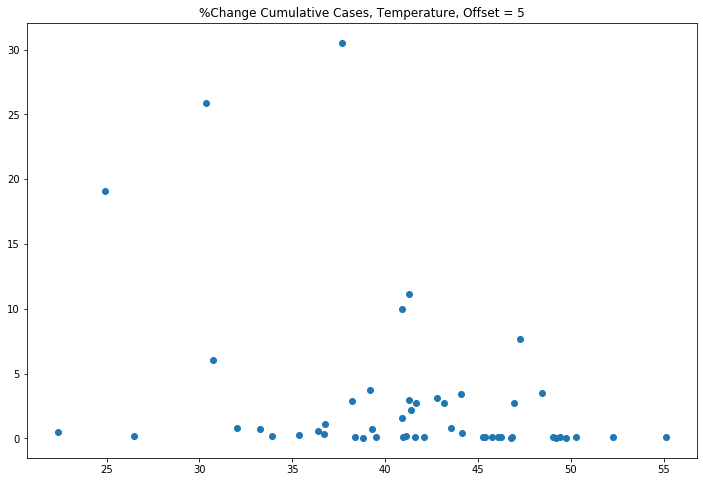

In [429]:
tcx = np.array([x[0] for x in offsetTempCases])
tcy = np.array([y[1] for y in offsetTempCases])
# Drops NAs that interfere with calculating regression
xandy = pd.DataFrame({'tcx':tcx,'tcy':tcy}).dropna(axis=0,how='any')

casesAndTemp(xandy['tcx'],xandy['tcy'])
plt.title('%Change Cumulative Cases, Temperature, Offset = 5')

slope, intercept, r_value, p_value, std_err = stats.linregress(xandy['tcx'],xandy['tcy'])

regressionResults.loc[('cases','temp',5),'RSQUARED'] = r_value**2
regressionResults.loc[('cases','temp',5),'PVALUE'] = p_value
regressionResults.loc[('cases','temp',5),'SLOPE'] = slope

Plot in which percent change in cumulative mortality from one day ago is plotted as a function of avg temperature one day ago

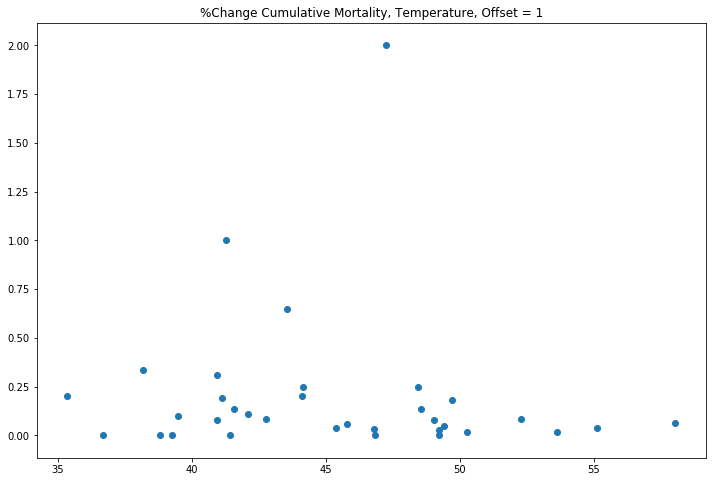

In [430]:
tcx = np.array([x[0] for x in tempMort])
tcy = np.array([y[1] for y in tempMort])
# Dropping invalid y-values
xandy = pd.DataFrame({'tcx':tcx,'tcy':tcy}).dropna(axis=0,how='any')
xandy = xandy.drop(16)

casesAndTemp(xandy['tcx'],xandy['tcy'])
plt.title('%Change Cumulative Mortality, Temperature, Offset = 1')

slope, intercept, r_value, p_value, std_err = stats.linregress(xandy['tcx'],xandy['tcy'])

regressionResults.loc[('mortality','temp',1),'RSQUARED'] = r_value**2
regressionResults.loc[('mortality','temp',1),'PVALUE'] = p_value
regressionResults.loc[('mortality','temp',1),'SLOPE'] = slope

Plot in which percent change in cumulative mortality from five days ago is plotted as a function of avg temperature five days ago

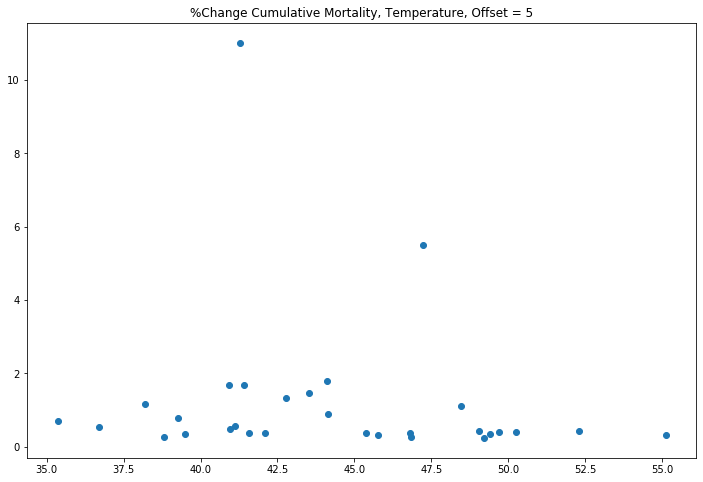

In [431]:
tcx = np.array([x[0] for x in offsetTempMort])
tcy = np.array([y[1] for y in offsetTempMort])
xandy = pd.DataFrame({'tcx':tcx,'tcy':tcy}).dropna(axis=0,how='any')
# Drop non-numerical y-values
xandy = xandy.drop([16,17,18,19,20])

casesAndTemp(xandy['tcx'],xandy['tcy'])
plt.title('%Change Cumulative Mortality, Temperature, Offset = 5')

slope, intercept, r_value, p_value, std_err = stats.linregress(xandy['tcx'],xandy['tcy'])

regressionResults.loc[('mortality','temp',5),'RSQUARED'] = r_value**2
regressionResults.loc[('mortality','temp',5),'PVALUE'] = p_value
regressionResults.loc[('mortality','temp',5),'SLOPE'] = slope

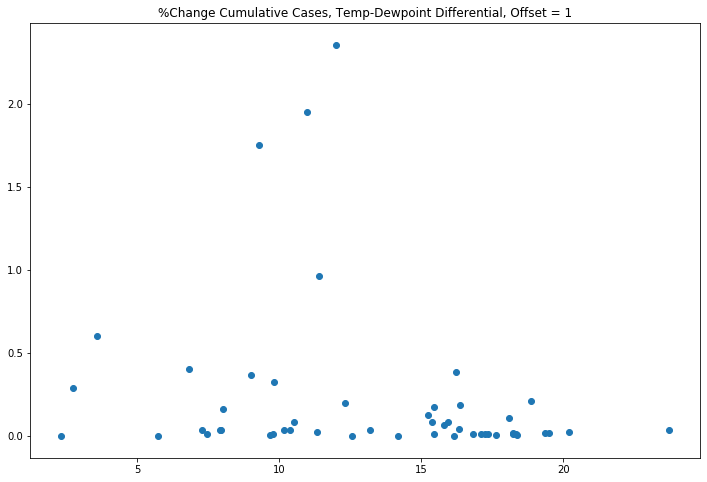

In [432]:
tcx = np.array([x[0] for x in diffCases])
tcy = np.array([y[1] for y in diffCases])
xandy = pd.DataFrame({'tcx':tcx,'tcy':tcy}).dropna(axis=0,how='any')

casesAndTemp(xandy['tcx'],xandy['tcy'])
plt.title('%Change Cumulative Cases, Temp-Dewpoint Differential, Offset = 1')

slope, intercept, r_value, p_value, std_err = stats.linregress(xandy['tcx'],xandy['tcy'])

regressionResults.loc[('cases','diff',1),'RSQUARED'] = r_value**2
regressionResults.loc[('cases','diff',1),'PVALUE'] = p_value
regressionResults.loc[('cases','diff',1),'SLOPE'] = slope

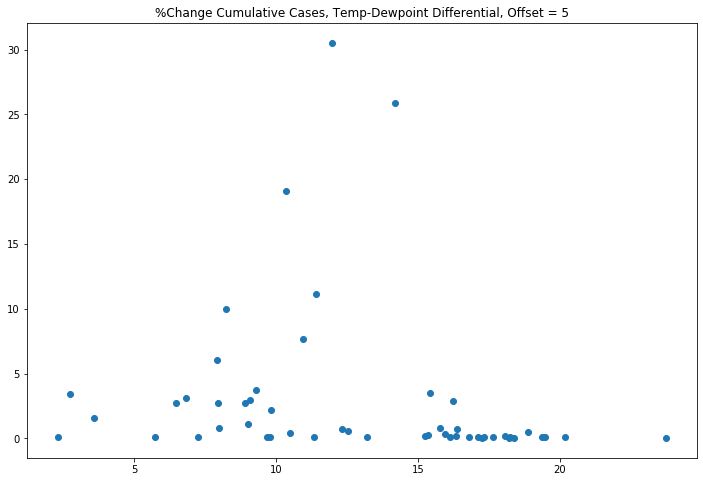

In [433]:
tcx = np.array([x[0] for x in offsetDiffCases])
tcy = np.array([y[1] for y in offsetDiffCases])
xandy = pd.DataFrame({'tcx':tcx,'tcy':tcy}).dropna(axis=0,how='any')

casesAndTemp(xandy['tcx'],xandy['tcy'])
plt.title('%Change Cumulative Cases, Temp-Dewpoint Differential, Offset = 5')

slope, intercept, r_value, p_value, std_err = stats.linregress(xandy['tcx'],xandy['tcy'])

regressionResults.loc[('cases','diff',5),'RSQUARED'] = r_value**2
regressionResults.loc[('cases','diff',5),'PVALUE'] = p_value
regressionResults.loc[('cases','diff',5),'SLOPE'] = slope

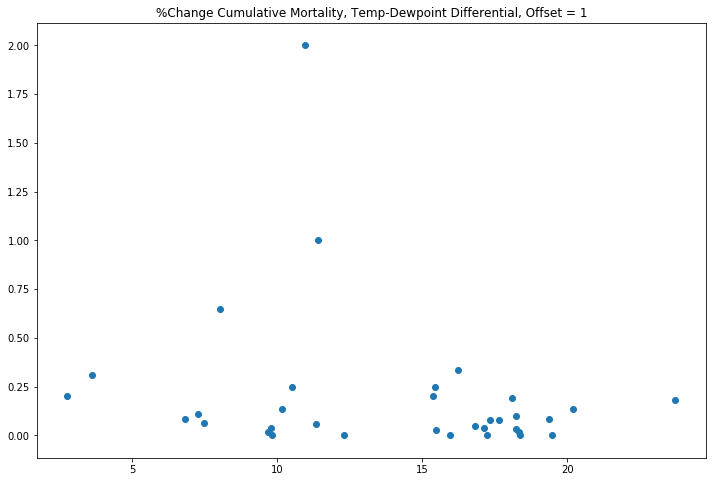

In [434]:
tcx = np.array([x[0] for x in diffMort])
tcy = np.array([y[1] for y in diffMort])
xandy = pd.DataFrame({'tcx':tcx,'tcy':tcy}).dropna(axis=0,how='any')
# Drop non-number values
xandy = xandy.drop(16)

casesAndTemp(xandy['tcx'],xandy['tcy'])
plt.title('%Change Cumulative Mortality, Temp-Dewpoint Differential, Offset = 1')

slope, intercept, r_value, p_value, std_err = stats.linregress(xandy['tcx'],xandy['tcy'])

regressionResults.loc[('mortality','diff',1),'RSQUARED'] = r_value**2
regressionResults.loc[('mortality','diff',1),'PVALUE'] = p_value
regressionResults.loc[('mortality','diff',1),'SLOPE'] = slope

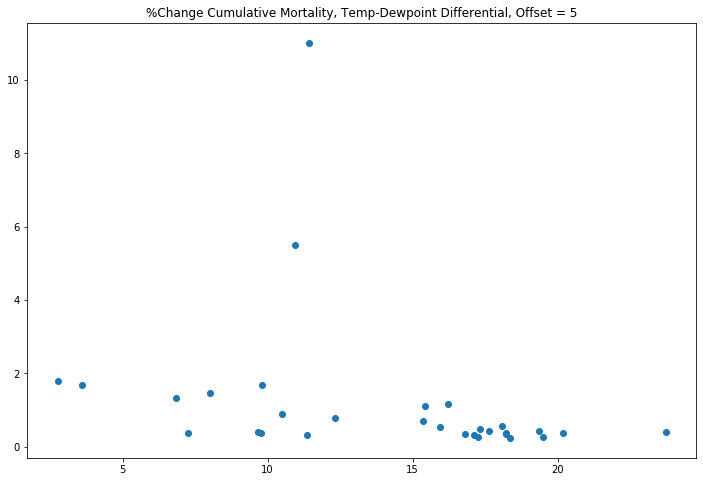

In [435]:
tcx = np.array([x[0] for x in offsetDiffMort])
tcy = np.array([y[1] for y in offsetDiffMort])
xandy = pd.DataFrame({'tcx':tcx,'tcy':tcy}).dropna(axis=0,how='any')
# Drop non-number values
xandy = xandy.drop([16,17,18,19,20])

casesAndTemp(xandy['tcx'],xandy['tcy'])
plt.title('%Change Cumulative Mortality, Temp-Dewpoint Differential, Offset = 5')

slope, intercept, r_value, p_value, std_err = stats.linregress(xandy['tcx'],xandy['tcy'])

regressionResults.loc[('mortality','diff',5),'RSQUARED'] = r_value**2
regressionResults.loc[('mortality','diff',5),'PVALUE'] = p_value
regressionResults.loc[('mortality','diff',5),'SLOPE'] = slope

In [436]:
regressionResults

RSQUARED     PVALUE       SLOPE
Measure   ClimateVar Timelag                                   
cases     temp       1        0.00803593   0.531596 -0.00576764
                     5          0.105178  0.0202449   -0.292033
          diff       1          0.046001   0.130697  -0.0212759
                     5         0.0284611   0.236641   -0.210215
mortality temp       1        0.00530573   0.682256 -0.00505391
                     5         0.0145609   0.525315  -0.0523866
          diff       1         0.0466762    0.21975  -0.0158804
                     5         0.0802007   0.129402   -0.114214

## Conclusion:
The results do not validate my hypothesis. The combination of factors that resulted in the strongest regression was Climate Variable: Temperature, Measure: % Change in total cases, Timelag: 5 days. While the p-value was less than .05, the R-squared value was only .105. Furthermore the overwhelming weakness of the other factor combinations, the fact that no potential confounding variables were addressed, and the potential of a non-linear relationship lead me to conclude that this analysis cannot claim that temperature or humidity has any mitigating effect on the spread of nCOVID-19

The only encouraging aspects of this analysis is the fact that the five-day offset resulted in a stronger relationship in three out of the four pairs of measurements. This may suggest that time lags are good practice when probing relationships between variables and the spread of nCOVID-19